## 0. 파일 업로드

In [3]:
from google.colab import drive
import zipfile

# Drive 마운트
drive.mount('/content/drive')

# train.zip 및 test2.zip 파일 경로 설정
train_zip_path = '/content/drive/MyDrive/train.zip'
test2_zip_path = '/content/drive/MyDrive/test2.zip'

# train.zip 파일 압축 해제
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('data/selected/train_ref')

# test2.zip 파일 압축 해제
with zipfile.ZipFile(test2_zip_path, 'r') as zip_ref:
    zip_ref.extractall('data/selected/test2')

# train_ref 및 test2 디렉토리의 경로 설정
train_path = 'data/selected/train_ref/train_ref'
test2_path = 'data/selected/test2/test2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 이미지 전처리

Execution Time: 0.13953280448913574 seconds


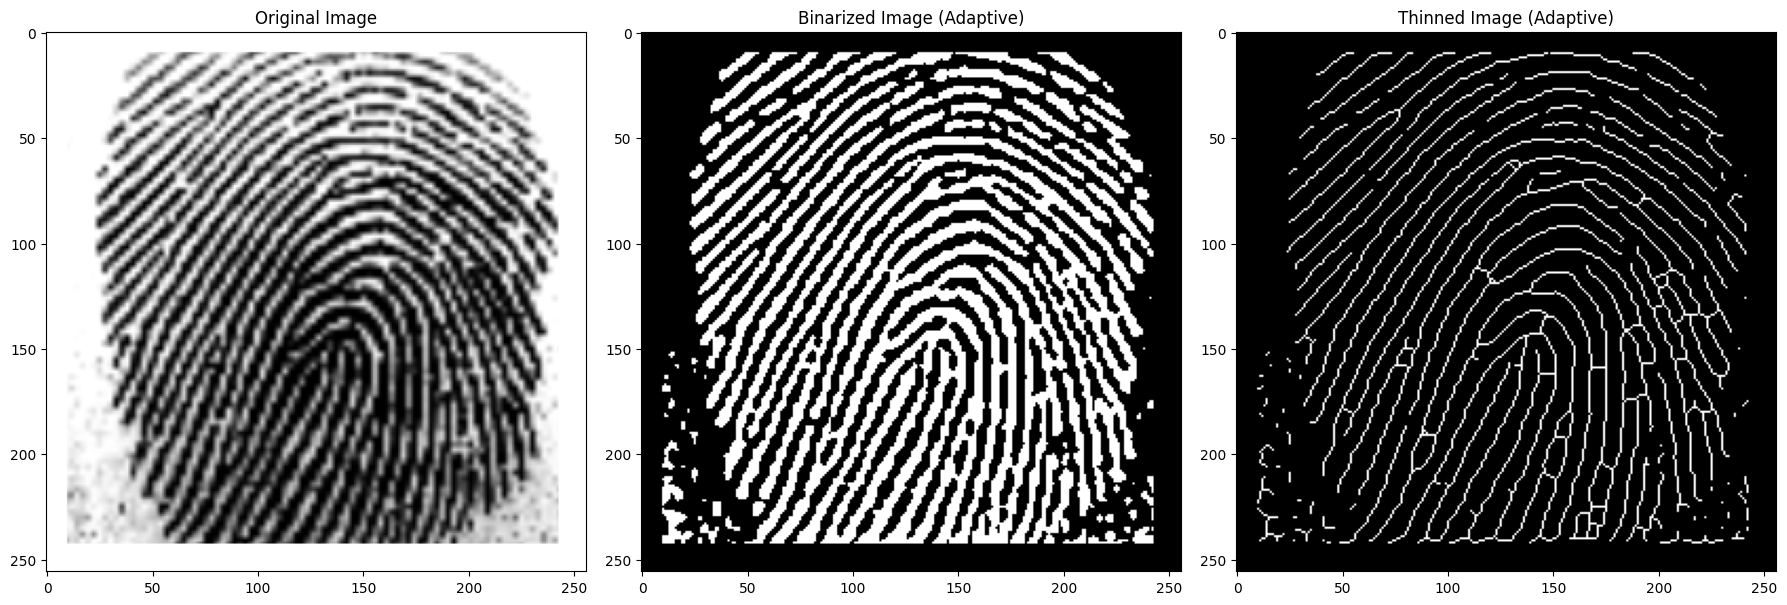

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import skeletonize



# 이미지 이진화
def binarize_image(img):
    thresh = threshold_otsu(img)
    binary_img = img > thresh
    return np.invert(binary_img)  # 이미지 반전

# Adaptive thresholding
def adaptive_binarize_image(img, block_size=35, offset=10):
    adaptive_thresh = threshold_local(img, block_size, offset=offset)
    binary_adaptive = img > adaptive_thresh
    return np.invert(binary_adaptive)  # 이미지 반전

# 이진화된 이미지 세선화
def thin_image(binary_img):
    thinned_img = skeletonize(binary_img)
    return thinned_img

# Set block size for local orientation calculation
block_size = 16

## Calculate local orientation
img_train = cv2.imread('/content/data/selected/train_ref/train_ref/100.BMP', cv2.IMREAD_GRAYSCALE)
img_test = cv2.imread('/content/data/selected/test2/test2/100_type1.BMP', cv2.IMREAD_GRAYSCALE)

# 시작 시간
start_time = time.time()

# Calculate local orientation
orientation1 = calculate_local_orientation(img_train, block_size)

# Binarize image using Otsu's method
binary_img_otsu = binarize_image(img_train)

# Binarize image using adaptive thresholding
binary_img_adaptive = adaptive_binarize_image(img_train)

# Thin image
thinned_img1_otsu = thin_image(binary_img_otsu)
thinned_img1_adaptive = thin_image(binary_img_adaptive)

# 종료 시간
end_time = time.time()

# 실행 시간 계산
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")


# Plot images
plt.figure(figsize=(18, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img_train, cmap='gray')

# Binarized Image (Adaptive)
plt.subplot(1, 3, 2)
plt.title('Binarized Image (Adaptive)')
plt.imshow(binary_img_adaptive, cmap='gray')

# Thinned Image (Adaptive)
plt.subplot(1, 3, 3)
plt.title('Thinned Image (Adaptive)')
plt.imshow(thinned_img1_adaptive, cmap='gray')

plt.tight_layout()
plt.show()


## 2. 특징 추출

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def minutiae_detection(thinned_img):
    rows, cols = thinned_img.shape
    minutiae_end = []
    minutiae_bif = []

    # 3x3 윈도우 기반 N8 및 CN 계산
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if thinned_img[i, j] == 1:
                # 3x3 윈도우 내의 8개 이웃 픽셀
                window = thinned_img[i-1:i+2, j-1:j+2]
                N = [window[0,1], window[0,2], window[1,2], window[2,2], window[2,1], window[2,0], window[1,0], window[0,0]]

                # Crossing Number (CN) 계산
                CN = 0
                for k in range(8):
                    CN += np.logical_xor(N[k], N[(k+1) % 8])
                CN /= 2

                # 종단점 검출: CN = 1
                if CN == 1:
                    minutiae_end.append((i, j))
                # 분기점 검출: CN = 3
                elif CN == 3:
                    minutiae_bif.append((i, j))

    return minutiae_end, minutiae_bif

Execution Time: 0.7192471027374268 seconds


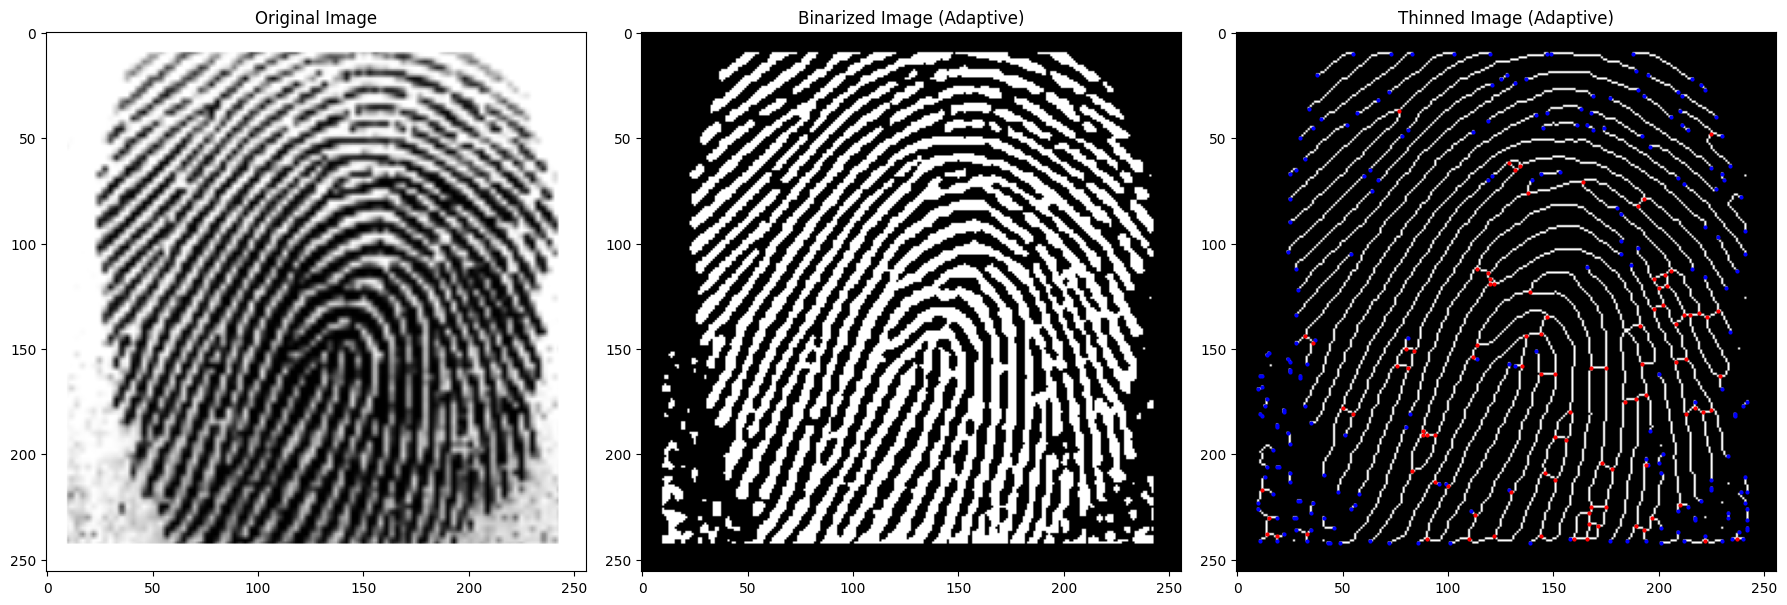

In [58]:
# 수행
block_size = 16

# 시작 시간
start_time = time.time()

# 특징점 검출 수행
minutiae_end, minutiae_bif = minutiae_detection(thinned_img1_adaptive)

# 종료 시간
end_time = time.time()

# 실행 시간 계산
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")


# 출력
	# Plot images
plt.figure(figsize=(18, 12))

	# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img_train, cmap='gray')

	# Binarized Image (Adaptive)
plt.subplot(1, 3, 2)
plt.title('Binarized Image (Adaptive)')
plt.imshow(binary_img_adaptive, cmap='gray')

	# Thinned Image (Adaptive)
plt.subplot(1, 3, 3)
plt.title('Thinned Image (Adaptive)')
plt.imshow(thinned_img1_adaptive, cmap='gray')

	# Plot minutiae points
for (i, j) in minutiae_end:
    plt.plot(j, i, 'bo', markersize=2)  # 종단점: 빨간색 점
for (i, j) in minutiae_bif:
    plt.plot(j, i, 'ro', markersize=2)  # 분기점: 파란색 점

plt.tight_layout()
plt.show()

### 2-1. 특징 검출 시간 단축

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def minutiae_detection(thinned_img, endpoint_threshold, bifurcation_threshold, margin):
    rows, cols = thinned_img.shape
    minutiae_end = []
    minutiae_bif = []

    # 3x3 윈도우 기반 N8 및 CN 계산
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if thinned_img[i, j] == 1:
                # 3x3 윈도우 내의 8개 이웃 픽셀
                window = thinned_img[i-1:i+2, j-1:j+2]
                N = [window[0,1], window[0,2], window[1,2], window[2,2], window[2,1], window[2,0], window[1,0], window[0,0]]

                # Crossing Number (CN) 계산
                CN = 0
                for k in range(8):
                    CN += np.logical_xor(N[k], N[(k+1) % 8])
                CN /= 2

                # 종단점 검출: CN = endpoint_threshold
                if CN == endpoint_threshold:
                    # 가장자리에서 일정 거리 이내에 있는 융선 끝점 제외
                    if margin <= i < rows - margin and margin <= j < cols - margin:
                        minutiae_end.append((i, j))
                # 분기점 검출: CN = bifurcation_threshold
                elif CN == bifurcation_threshold:
                    minutiae_bif.append((i, j))

    return minutiae_end, minutiae_bif


Execution Time: 0.19666671752929688 seconds


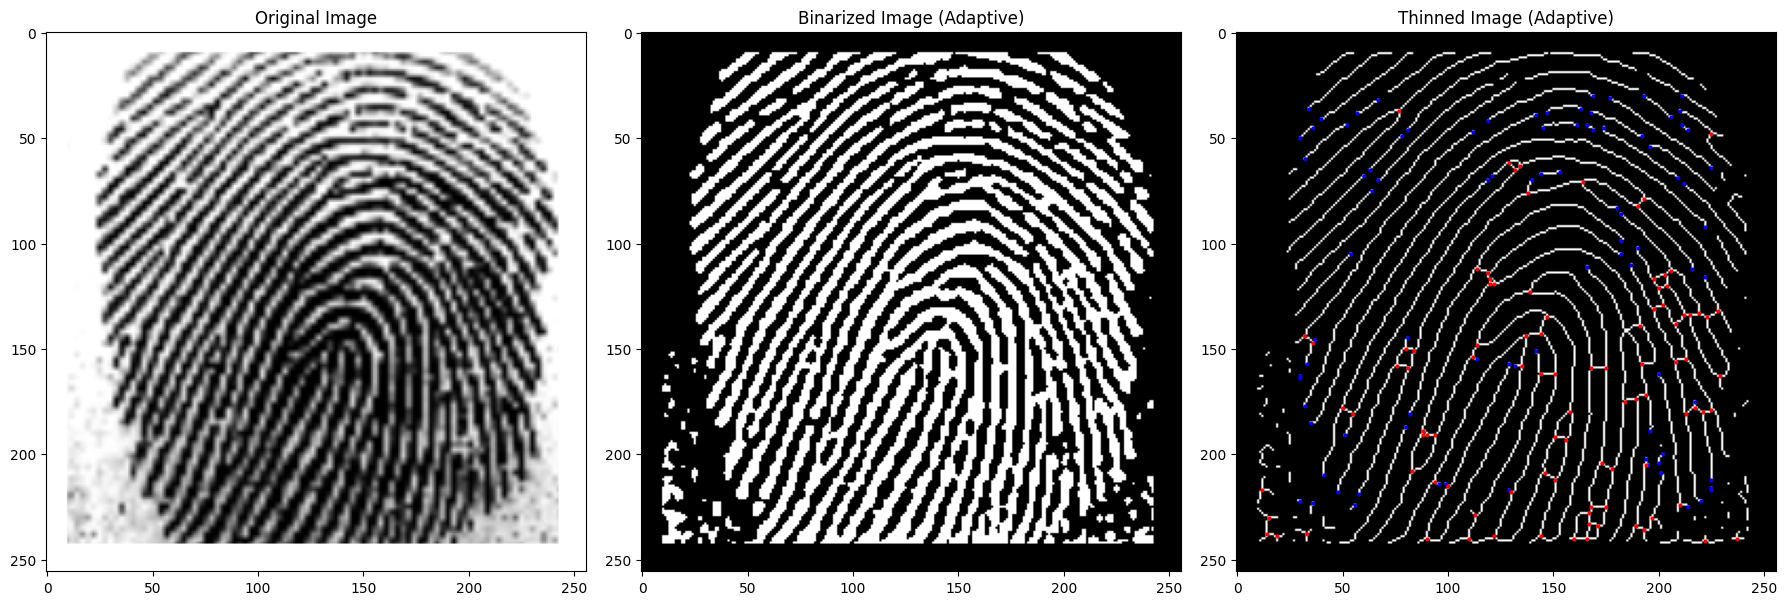

In [56]:
# 수행
block_size = 16

# 시작 시간
start_time = time.time()

# 특징점 검출 수행
minutiae_end, minutiae_bif = minutiae_detection(thinned_img1_adaptive, endpoint_threshold=1, bifurcation_threshold=3, margin=30)

# 종료 시간
end_time = time.time()

# 실행 시간 계산
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")


# 출력
	# Plot images
plt.figure(figsize=(18, 12))

	# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img_train, cmap='gray')

	# Binarized Image (Adaptive)
plt.subplot(1, 3, 2)
plt.title('Binarized Image (Adaptive)')
plt.imshow(binary_img_adaptive, cmap='gray')

	# Thinned Image (Adaptive)
plt.subplot(1, 3, 3)
plt.title('Thinned Image (Adaptive)')
plt.imshow(thinned_img1_adaptive, cmap='gray')

	# Plot minutiae points
for (i, j) in minutiae_end:
    plt.plot(j, i, 'bo', markersize=2)  # 종단점: 빨간색 점
for (i, j) in minutiae_bif:
    plt.plot(j, i, 'ro', markersize=2)  # 분기점: 파란색 점

plt.tight_layout()
plt.show()

## 3. 매칭

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

def adaptive_binarize_image(img):
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    inverted_img = cv2.bitwise_not(binary_img)
    return inverted_img

def thin_image(img):
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thinned_img = cv2.ximgproc.thinning(binary_img)
    return thinned_img

def extract_features(img):
    binary_img = adaptive_binarize_image(img)
    thinned_img = thin_image(binary_img)
    features = cv2.goodFeaturesToTrack(thinned_img, 100, 0.01, 10)
    if features is not None:
        return features.reshape(-1, 2).astype(np.float32)
    return np.empty((0, 2), dtype=np.float32)

def match_finger(feat_query, feat_train):
    if feat_query is None or feat_train is None or len(feat_query) == 0 or len(feat_train) == 0:
        return float('inf'), 0  # Return infinite distance if no features to match

    # Manual calculation of Euclidean distances for each feature match
    distances = []
    for fq in feat_query:
        min_dist = float('inf')
        for ft in feat_train:
            dist = np.linalg.norm(fq - ft)
            if dist < min_dist:
                min_dist = dist
        distances.append(min_dist)

    if distances:
        sum_distance = sum(distances)
    else:
        sum_distance = float('inf')

    return sum_distance, len(distances

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# 파일 경로 설정
train_path = 'data/selected/train_ref/train_ref'
test_path = 'data/selected/test2/test2'
output_file = 'result.txt'

# 테스트 파일 목록을 정렬하여 가져옴
test_files = sorted([f for f in os.listdir(test_path) if f.startswith('100_type1') or f > '100_type1'])

# 결과 파일 초기화
with open(output_file, 'w') as file:
    file.write("")

# 테스트 파일 순회
for test_file in tqdm(test_files):
    test_image_path = os.path.join(test_path, test_file)
    img_test = cv2.imread(test_image_path)
    feat_query = extract_features(img_test)

    best_distance = float('inf')
    best_match_count = 0
    best_train_image = None

    # 학습 파일 순회
    for train_file in os.listdir(train_path):
        train_image_path = os.path.join(train_path, train_file)
        img_train = cv2.imread(train_image_path)
        feat_train = extract_features(img_train)

        distance, match_count = match_finger(feat_query, feat_train)

        if distance < best_distance:
            best_distance = distance
            best_match_count = match_count
            best_train_image = train_image_path

    # 결과 파일에 기록
    with open(output_file, 'a') as file:
        file.write(f"Test image: {test_image_path}\nBest match distance: {best_distance}, Match count: {best_match_count}, Match image: {best_train_image}\n\n")

print(f"Results have been written to {output_file}")


## 4. Metric 계산

In [45]:
def read_results(file_path):
    results = []
    with open(file_path, 'r') as file:
        for line in file:
            if "Best match distance:" in line:  # "Best match distance:"를 포함하는 줄을 찾음
                match_distance = float(line.split("Best match distance:")[1].split(',')[0].strip())  # 매칭 거리를 추출
                if match_distance < threshold:  # 임계값을 설정하여 매칭 성공 여부를 결정
                    results.append(1)  # 매칭 성공
                else:
                    results.append(0)  # 매칭 실패
    return results

def calculate_metrics(results):
    total_tests = len(results)
    successful_matches = sum(results)
    unsuccessful_matches = total_tests - successful_matches
    true_positive = sum(results)
    false_positive = total_tests - true_positive
    false_negative = total_tests - true_positive
    true_negative = successful_matches

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    far = false_positive / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    frr = false_negative / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative) if total_tests != 0 else 0

    return precision, recall, far, frr, accuracy

file_path = 'result.txt'
threshold = 300  # 임계값 설정
results = read_results(file_path)
precision, recall, far, frr, accuracy = calculate_metrics(results)

print("Precision:", precision)
print("Recall:", recall)
print("False Acceptance Rate (FAR):", far)
print("False Rejection Rate (FRR):", frr)
print("Accuracy:", accuracy)

Precision: 0.930327868852459
Recall: 0.930327868852459
False Acceptance Rate (FAR): 0.06967213114754098
False Rejection Rate (FRR): 0.06967213114754098
Accuracy: 0.930327868852459
